## Задача классификации Мобильных игр


# Задача
Имеем датасет с более, чем с 17000 мобильных игр.
Задача: имея различную информцию об игре, отнести ее к определенному возрастному классу: 4+, 9+, 12+ или 17+

## 1. Загружаем данные

In [7]:
import pandas as pd   

In [8]:
from numba import njit
from numba import jit

In [9]:
import numpy as np            
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns          
import sklearn   

In [10]:
from sklearn.metrics import r2_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import datetime

In [11]:
url = "https://raw.githubusercontent.com/ErmachenkoBoris/machineLearning/master/datasets/appstore_games.csv"
data_raw = pd.read_csv(url)

In [12]:
data_raw.shape


(17007, 18)

In [13]:
data_raw.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


In [14]:
data_raw.columns

Index(['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'Average User Rating',
       'User Rating Count', 'Price', 'In-app Purchases', 'Description',
       'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre',
       'Genres', 'Original Release Date', 'Current Version Release Date'],
      dtype='object')

Мы видим, что мы имеем следующие столбцы и признаки:

- `URL` - url на игру
- `ID` - id игры
- `Name` - имя игры
- `Subtitle` - подзаголовок, 
- `Icon URL` - url на иконку,
- `Average User Rating` - числовой признак, рейтинг игры,
- `User Rating Count` - числовой признак, количество оценок,
- `Price` - числовой признак, цена,
- `In-app Purchases` - бинарный признак, покупки внутри приложения,
- `Description` - описание, номинальный признак,
- `Developer` - разработчик, категориальный признак,
- `Age Rating` - возрастное ограничение, номинальный(категориальный признак),
- `Languages` - номинальный признак, языки,
- `Size` - размер приложения, количественный признак,
- `Primary Genre` - основной жанр, номинальный признак,
- `Genres` -поджанр, номинальный признак,
- `Original Release Date` - дата первого релиза, номинальный признак 
- `Current Version Release Date` - дата последнего релиза, номинальный признак


Требуется отнести игру к одному из возрастному ограничению, имея всю остальную информацию об игре


Столбцы `'Age Rating'`, `'Primary Genre'`, `'Developer'` содержат категориальное значение

In [15]:
data_raw['Age Rating'] = data_raw['Age Rating'].astype('category')

In [16]:
data_raw['Primary Genre'] = data_raw['Primary Genre'].astype('category')

In [17]:
data_raw['Developer'] = data_raw['Developer'].astype('category')


In [18]:
data_raw['Age Rating'].dtype

CategoricalDtype(categories=['12+', '17+', '4+', '9+'], ordered=False)

In [19]:
data_raw['Primary Genre'].dtype

CategoricalDtype(categories=['Book', 'Business', 'Education', 'Entertainment', 'Finance',
                  'Food & Drink', 'Games', 'Health & Fitness', 'Lifestyle',
                  'Medical', 'Music', 'Navigation', 'News', 'Productivity',
                  'Reference', 'Shopping', 'Social Networking', 'Sports',
                  'Stickers', 'Travel', 'Utilities'],
                 ordered=False)

In [20]:
data_raw['Developer'].dtype

CategoricalDtype(categories=['"Alex Artem'ev"', '"ByteRockers' Games GmbH & Co. KG"',
                  '"Daniel O'Sullivan"', '"Don't Blink Studios"',
                  '"Ellie's Games, LLC"', '"Galen O'Shea"',
                  '"Igor's Software Labs LLC"', '"It's All A Game LLC"',
                  '"Joe o'donovan"', '"Joe's Apps"',
                  ...
                  'zhiguo lin', 'zhijuan zhang', 'zhili zhao', 'zhixiang zhao',
                  'zhong chen', 'zhou zhimeng',
                  'zinWorks Studios (zinCode, LLC)', 'zomido med',
                  'zuiyouqu youxi', 'zurab inaishvili'],
                 ordered=False)

### Преобразование столбцов

In [21]:
data_raw.loc[:, 'Genres']

0                       Games, Strategy, Puzzle
1                        Games, Strategy, Board
2                        Games, Board, Strategy
3                       Games, Strategy, Puzzle
4             Games, Strategy, Board, Education
                          ...                  
17002    Games, Entertainment, Casual, Strategy
17003                   Games, Family, Strategy
17004                           Games, Strategy
17005                   Games, Strategy, Action
17006                   Games, Strategy, Puzzle
Name: Genres, Length: 17007, dtype: object

Заметим, что значение `'Genres'` содержит несколько жанров
Для того, чтобы анализировать этот признак, лучше создать для каждого столбец со значениями:
0 - если данный жанр не присутсвует в игре,
1 - если жанр присутсвует в данной игре
(бинарный признак)
Для этого необходимо сначала узнать, как жанры вообще есть

In [22]:
# поиск жанров

genres_array = []
for index, row in data_raw.iterrows():
    genres_row = row['Genres'].split(', ');
    if len(genres_array) == 0 and len(genres_row)>0:
        genres_array = genres_row[:];
    elif len(genres_row)>0:
         genres_array.extend(genres_row);
uniq = list(dict.fromkeys(genres_array))

получили массив с уникальными значениями жанров:

In [23]:
print(uniq)

['Games', 'Strategy', 'Puzzle', 'Board', 'Education', 'Entertainment', 'Casual', 'Action', 'Card', 'Simulation', 'Finance', 'Word', 'Role Playing', 'Sports', 'Adventure', 'Family', 'Travel', 'Casino', 'Business', 'Navigation', 'Reference', 'Lifestyle', 'Social Networking', 'Medical', 'Utilities', 'Trivia', 'Racing', 'Books', 'Music', 'Productivity', 'Health & Fitness', 'Food & Drink', 'News', 'Photo & Video', 'Stickers', 'Emoji & Expressions', 'Sports & Activities', 'Gaming', 'Comics & Cartoons', 'Animals & Nature', 'People', 'Shopping', 'Kids & Family', 'Art', 'Places & Objects', 'Weather', 'Magazines & Newspapers']


отсортируем его:

In [24]:
uniq.sort()
print(uniq)

['Action', 'Adventure', 'Animals & Nature', 'Art', 'Board', 'Books', 'Business', 'Card', 'Casino', 'Casual', 'Comics & Cartoons', 'Education', 'Emoji & Expressions', 'Entertainment', 'Family', 'Finance', 'Food & Drink', 'Games', 'Gaming', 'Health & Fitness', 'Kids & Family', 'Lifestyle', 'Magazines & Newspapers', 'Medical', 'Music', 'Navigation', 'News', 'People', 'Photo & Video', 'Places & Objects', 'Productivity', 'Puzzle', 'Racing', 'Reference', 'Role Playing', 'Shopping', 'Simulation', 'Social Networking', 'Sports', 'Sports & Activities', 'Stickers', 'Strategy', 'Travel', 'Trivia', 'Utilities', 'Weather', 'Word']


Теперь, когда мы узнали список признаков, добавим их в нашу таблицу:

In [25]:
for genre in uniq:
    data_raw[genre] = 0

In [26]:
data_raw.columns

Index(['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'Average User Rating',
       'User Rating Count', 'Price', 'In-app Purchases', 'Description',
       'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre',
       'Genres', 'Original Release Date', 'Current Version Release Date',
       'Action', 'Adventure', 'Animals & Nature', 'Art', 'Board', 'Books',
       'Business', 'Card', 'Casino', 'Casual', 'Comics & Cartoons',
       'Education', 'Emoji & Expressions', 'Entertainment', 'Family',
       'Finance', 'Food & Drink', 'Games', 'Gaming', 'Health & Fitness',
       'Kids & Family', 'Lifestyle', 'Magazines & Newspapers', 'Medical',
       'Music', 'Navigation', 'News', 'People', 'Photo & Video',
       'Places & Objects', 'Productivity', 'Puzzle', 'Racing', 'Reference',
       'Role Playing', 'Shopping', 'Simulation', 'Social Networking', 'Sports',
       'Sports & Activities', 'Stickers', 'Strategy', 'Travel', 'Trivia',
       'Utilities', 'Weather', 'Word'],
      dtype=

присвоим значение 1, если данный тип пристутсвует в жанрах игры

In [27]:
for index, row in data_raw.iterrows():
    for genre in uniq:
        if row['Genres'].find(genre) >= 0:
            data_raw.loc[index, genre] = 1

Проделаем тоже самое для столбца с языками, так как он тоже содержит набор различных параметров

In [28]:
data_raw['Languages'].dtype

dtype('O')

In [29]:
import math

In [30]:
# поиск языков
# если значение пропущено, то будем считать, что игра на английском языке
len_array = []
for index, row in data_raw.iterrows():
    if not row['Languages'] is np.nan:
      len_row = row['Languages'].split(', ');
      if len(len_array) == 0 and len(len_row)>0:
          len_array = len_row[:];
      elif len(len_row)>0:
                  len_array.extend(len_row);
    else:
       data_raw.loc[index, 'Languages'] = 'EN'
uniq = list(dict.fromkeys(len_array))

In [31]:
uniq.sort()
print(uniq)

['AF', 'AM', 'AR', 'AS', 'AY', 'AZ', 'BE', 'BG', 'BN', 'BO', 'BR', 'BS', 'CA', 'CS', 'CY', 'DA', 'DE', 'DZ', 'EL', 'EN', 'EO', 'ES', 'ET', 'EU', 'FA', 'FI', 'FO', 'FR', 'GA', 'GD', 'GL', 'GN', 'GU', 'GV', 'HE', 'HI', 'HR', 'HU', 'HY', 'ID', 'IS', 'IT', 'IU', 'JA', 'JV', 'KA', 'KK', 'KL', 'KM', 'KN', 'KO', 'KR', 'KS', 'KU', 'KY', 'LA', 'LO', 'LT', 'LV', 'MG', 'MI', 'MK', 'ML', 'MN', 'MR', 'MS', 'MT', 'MY', 'NB', 'NE', 'NL', 'NN', 'NO', 'OM', 'OR', 'PA', 'PL', 'PS', 'PT', 'QU', 'RN', 'RO', 'RU', 'RW', 'SA', 'SD', 'SE', 'SI', 'SK', 'SL', 'SO', 'SQ', 'SR', 'SU', 'SV', 'SW', 'TA', 'TE', 'TG', 'TH', 'TI', 'TK', 'TL', 'TO', 'TR', 'TT', 'UG', 'UK', 'UR', 'UZ', 'VI', 'XH', 'YI', 'ZH', 'ZU']


In [32]:
#добавляем новые столбцы и заполняем нулями
for lang in uniq:
    data_raw[lang] = 0

In [33]:
#если игра содержит данный язык ставим 1 в соотвествующий столбец
for index, row in data_raw.iterrows():
    for lan in uniq:
        if row['Languages'].find(lan) >= 0:
            data_raw.loc[index, lan] = 1

In [34]:
data_raw.columns

Index(['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'Average User Rating',
       'User Rating Count', 'Price', 'In-app Purchases', 'Description',
       ...
       'TT', 'UG', 'UK', 'UR', 'UZ', 'VI', 'XH', 'YI', 'ZH', 'ZU'],
      dtype='object', length=179)

## Преобразование столбцов с датой

In [35]:
# приводим строки с датой к дате
import datetime as DT


for index, row in data_raw.iterrows():
    data_raw.loc[index, 'Original Release Date'] = DT.datetime.strptime(row['Original Release Date'], '%d/%m/%Y').date()
    data_raw.loc[index, 'Current Version Release Date'] = DT.datetime.strptime(row['Current Version Release Date'], '%d/%m/%Y').date()

In [36]:
# преобразуем даты в числовое значение


for index, row in data_raw.iterrows():
  date1 = row['Original Release Date']
  date2 = row['Current Version Release Date']
  data_raw.loc[index, 'Original Release Date'] = (DT.datetime.now() - datetime(date1.year, date1.month, date1.day)).total_seconds()
  data_raw.loc[index, 'Current Version Release Date'] = (DT.datetime.now() - datetime(date2.year, date2.month, date2.day)).total_seconds()

In [37]:
# проверка
data_raw.loc[:10, 'Original Release Date']


0     3.86832e+08
1     3.86832e+08
2     3.86832e+08
3     3.85795e+08
4     3.86227e+08
5      3.8519e+08
6      3.8519e+08
7     3.84845e+08
8     3.84845e+08
9     3.85018e+08
10    3.84154e+08
Name: Original Release Date, dtype: object

In [38]:
data_raw.loc[:10, 'Current Version Release Date']

0     1.06464e+08
1     7.60512e+07
2     9.79968e+07
3     1.06464e+08
4     7.03488e+07
5     4.60704e+07
6     2.18179e+08
7     6.40416e+07
8     9.11712e+07
9     3.85018e+08
10    3.79834e+08
Name: Current Version Release Date, dtype: object

### Удаление ненужных столбцов
после преобразований столбцы '`Genres`' и '`Languages`' больше не нужны, удалим их


In [39]:
data_raw.drop(['Genres', 'Languages'], axis='columns', inplace=True)
data_raw.columns

Index(['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'Average User Rating',
       'User Rating Count', 'Price', 'In-app Purchases', 'Description',
       ...
       'TT', 'UG', 'UK', 'UR', 'UZ', 'VI', 'XH', 'YI', 'ZH', 'ZU'],
      dtype='object', length=177)

Кроме того, очевидно, что столбцы, содержащие URL никак нам не помогут решить поставленную задачу. Удалим их тоже

In [40]:
data_raw.drop(['URL', 'Icon URL'], axis='columns', inplace=True)

Также столбцы с индексом, именем и описание и подзаголовком тоже нам не помогут

In [41]:
data_raw.drop(['ID', 'Name', 'Subtitle', 'Description'], axis='columns', inplace=True)

In [42]:
data_raw.columns

Index(['Average User Rating', 'User Rating Count', 'Price', 'In-app Purchases',
       'Developer', 'Age Rating', 'Size', 'Primary Genre',
       'Original Release Date', 'Current Version Release Date',
       ...
       'TT', 'UG', 'UK', 'UR', 'UZ', 'VI', 'XH', 'YI', 'ZH', 'ZU'],
      dtype='object', length=171)

## Заполнение пропущенных значений

In [43]:
pd.options.display.max_rows = 200
data_raw.isna().sum() 

Average User Rating             9446
User Rating Count               9446
Price                             24
In-app Purchases                9324
Developer                          0
Age Rating                         0
Size                               1
Primary Genre                      0
Original Release Date              0
Current Version Release Date       0
Action                             0
Adventure                          0
Animals & Nature                   0
Art                                0
Board                              0
Books                              0
Business                           0
Card                               0
Casino                             0
Casual                             0
Comics & Cartoons                  0
Education                          0
Emoji & Expressions                0
Entertainment                      0
Family                             0
Finance                            0
Food & Drink                       0
G

In [44]:
data_raw.loc[:18, 'In-app Purchases']

0                                          NaN
1                                          NaN
2                                          NaN
3                                          NaN
4                                          NaN
5                                         1.99
6                                          NaN
7                                          NaN
8                                          NaN
9                                          NaN
10                                         NaN
11                                         NaN
12                                         NaN
13                                         NaN
14                                         NaN
15                                        0.99
16                                        0.99
17                                         NaN
18    1.99, 0.99, 1.99, 0.99, 4.99, 1.99, 1.99
Name: In-app Purchases, dtype: object

Так как цены есть числовая характеристика, то преобразовывать этот столбец в различные признаки (как с language и genre) смысла нет.
Вместо этого будем считать, что если информация об этом признаке не указана - то внутренних покупок нет, а если есть, то они есть. Таким образом, превратим этот признак в бинарный

In [45]:
for index, row in data_raw.iterrows():
  if row['In-app Purchases'] is np.nan:
    data_raw.loc[index, 'In-app Purchases'] = 0
  else:
    data_raw.loc[index, 'In-app Purchases'] = 1

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам:


In [46]:
data_raw.fillna(data_raw.median(axis = 0), axis=0 , inplace=True)

In [47]:
data_raw.isna().sum() 

Average User Rating             0
User Rating Count               0
Price                           0
In-app Purchases                0
Developer                       0
Age Rating                      0
Size                            0
Primary Genre                   0
Original Release Date           0
Current Version Release Date    0
Action                          0
Adventure                       0
Animals & Nature                0
Art                             0
Board                           0
Books                           0
Business                        0
Card                            0
Casino                          0
Casual                          0
Comics & Cartoons               0
Education                       0
Emoji & Expressions             0
Entertainment                   0
Family                          0
Finance                         0
Food & Drink                    0
Games                           0
Gaming                          0
Health & Fitne

Ура! мы избавили от нулевых значений

## Боремся с выбросами
От чего зависит возрастное ограничение для игры в первую очередь ?
Ответ на этот вопрос не очевиден


Попробуем посмотреть разброс по цене и по рейтингу

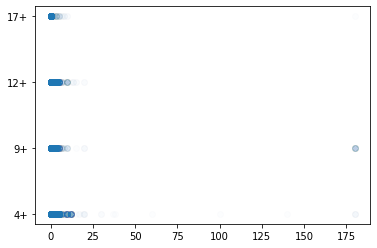

In [48]:
plt.scatter(data_raw['Price'], data_raw['Age Rating'], alpha=0.01)

In [49]:
data_raw['Price'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     0.00
0.010     0.00
0.050     0.00
0.100     0.00
0.500     0.00
0.900     0.99
0.950     2.99
0.990     9.99
0.995    11.99
Name: Price, dtype: float64

Вывод: 99.5% игр стоят меньше, чем 11.99

Проделаем тоже самое для рейтинга

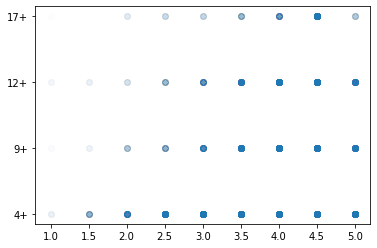

In [50]:
plt.scatter(x='Average User Rating', y='Age Rating', data = data_raw, alpha=0.01)

In [51]:
data_raw['Average User Rating'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005    2.0
0.010    2.0
0.050    3.0
0.100    3.5
0.500    4.5
0.900    4.5
0.950    5.0
0.990    5.0
0.995    5.0
Name: Average User Rating, dtype: float64

Удалим значения, в которых '`Price`' выходит за пределы 0.995, а '`Average User Rating`' менее 0.005

In [52]:
rows_to_drop = data_raw[
     (data_raw['Price'] > data_raw['Price'].quantile(0.995)) | 
    (data_raw['Average User Rating']  < data_raw['Average User Rating' ].quantile(0.005))].index
data = data_raw.drop(rows_to_drop)
data.shape

(16877, 171)

### Выбросы по датам

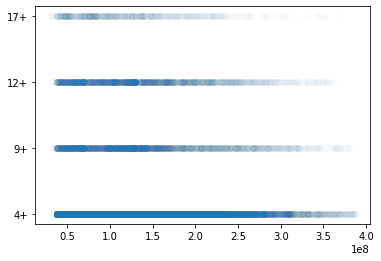

In [53]:
plt.scatter(x='Original Release Date', y='Age Rating', data=data_raw, alpha=0.01)

Делаем вывод по графику, что явных выбросов здесь нет

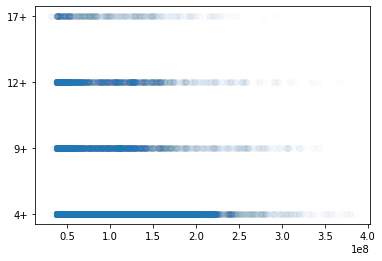

In [54]:
plt.scatter(x='Current Version Release Date', y='Age Rating', data=data_raw, alpha=0.01)

Аналогично, так как значения увеличивают/уменьшают плотность равномерно, выбросов нет

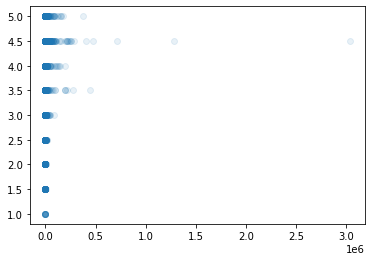

In [55]:
# проделаем для User Rating Count
plt.scatter(x='User Rating Count', y='Average User Rating', data=data_raw, alpha=0.1)

In [56]:
data_raw['User Rating Count'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005        5.00
0.010        5.00
0.050        7.00
0.100       11.00
0.500       46.00
0.900      407.00
0.950     1934.80
0.990    24680.68
0.995    48840.02
Name: User Rating Count, dtype: float64

In [57]:
# удаляем выбросы
rows_to_drop = data_raw[
     (data_raw['User Rating Count'] > data_raw['User Rating Count'].quantile(0.995)) | 
    (data_raw['User Rating Count']  < data_raw['User Rating Count' ].quantile(0.005))].index
data = data_raw.drop(rows_to_drop)
data.shape

(16921, 171)

# Визуализация и описательная статистика

Сейчас мы имеем очень много признаков из-за добавления признаков для языков и жанров.
Для визуализации оставим только изначальные

In [58]:
data_vis = data_raw.filter(['Average User Rating','User Rating Count','Price', 'In-app Purchases', 'Size', 'Original Release Date', 'Current Version Release Date', 'Primary Genre', 'Developer', 'Age Rating'], axis=1)

In [59]:
data_vis.describe()

,Average User Rating,User Rating Count,Price,In-app Purchases,Size,Original Release Date,Current Version Release Date
count,17007.000000,1.700700e+04,17007.000000,17007.000000,1.700700e+04,1.700700e+04,1.700700e+04
mean,4.304786,1.495572e+03,0.812271,0.451755,1.157030e+08,1.454486e+08,1.093760e+08
std,0.546465,2.826484e+04,7.830260,0.497682,2.036422e+08,7.214122e+07,5.753410e+07
min,1.000000,5.000000e+00,0.000000,0.000000,5.132800e+04,3.051840e+07,3.051840e+07
25%,4.500000,4.600000e+01,0.000000,0.000000,2.295040e+07,8.996159e+07,5.998079e+07
50%,4.500000,4.600000e+01,0.000000,0.000000,5.676895e+07,1.345440e+08,1.017120e+08
75%,4.500000,4.600000e+01,0.000000,1.000000,1.330130e+08,1.911360e+08,1.417152e+08
max,5.000000,3.032734e+06,179.990000,1.000000,4.005591e+09,3.868320e+08,3.850176e+08


Для каждого количественного признака приведены средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей.

Для категориальных признаков:

In [60]:
data_vis.describe(include=['category'])

,Primary Genre,Developer,Age Rating
count,17007,17007,17007
unique,21,8693,4
top,Games,Tapps Tecnologia da Informa\xe7\xe3o Ltda.,4+
freq,16286,123,11806


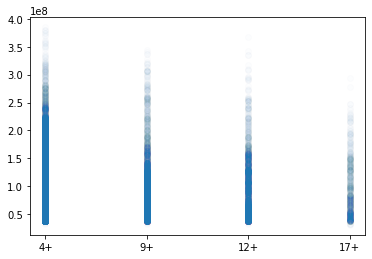

In [61]:
plt.scatter(x='Age Rating', y='Current Version Release Date', data=data_raw, alpha=0.01)

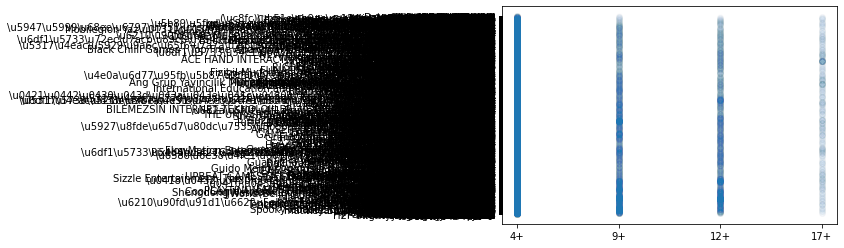

In [62]:
plt.scatter(x='Age Rating', y='Developer', data=data_raw, alpha=0.01)

In [63]:
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)

Построим все возможные диаграммы рассеивания для каждой пары переменных:

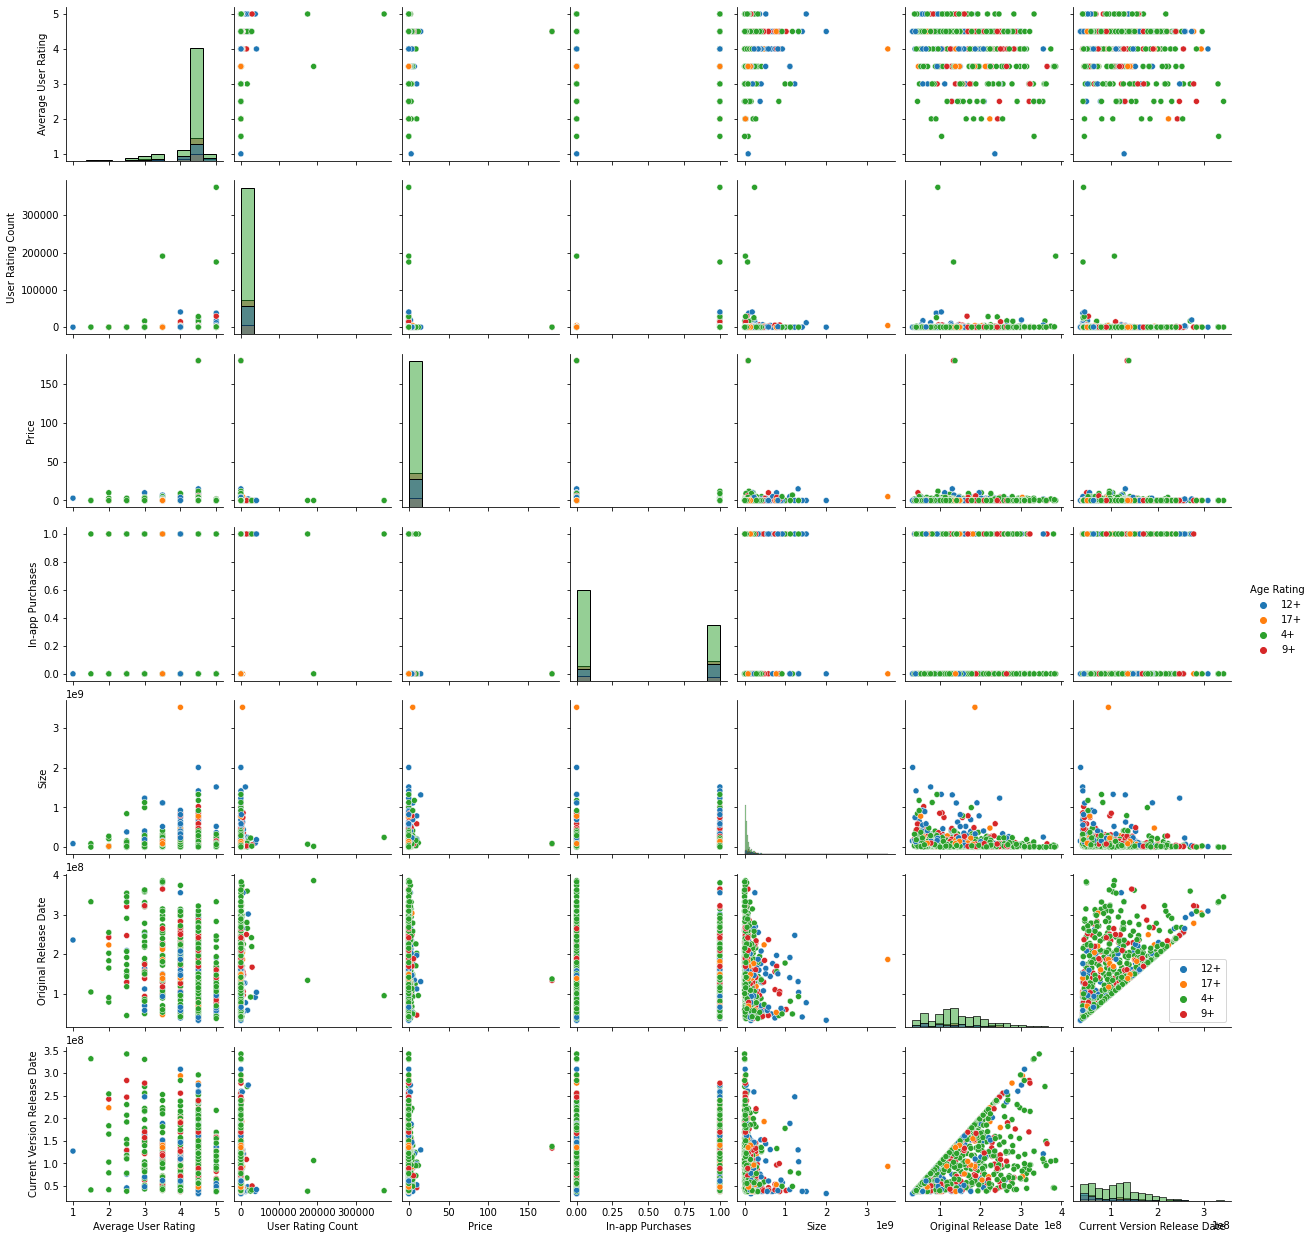

In [64]:
sns.pairplot(data_vis.iloc[random_subset], hue='Age Rating', diag_kind='hist')
plt.legend()
pass

Построим различные гистограммы

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


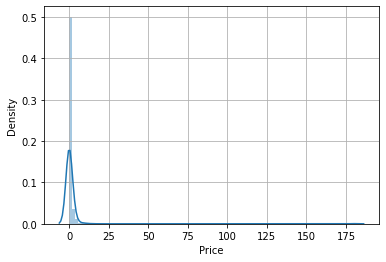

In [65]:
sns.distplot(data_vis.iloc[random_subset]['Price'], bins=100)
plt.grid()
pass

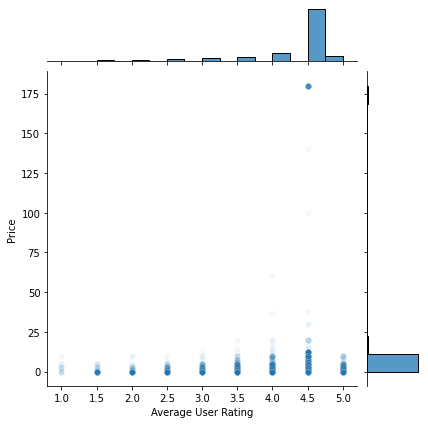

In [66]:
sns.jointplot(x='Average User Rating', y='Price', alpha=.05, data=data_vis)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


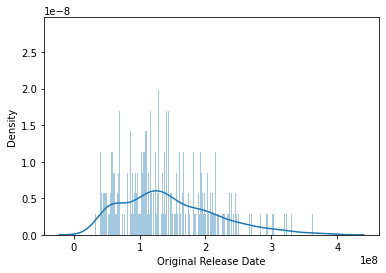

In [67]:
sns.distplot(data_vis.iloc[random_subset]['Original Release Date'], bins=1000)

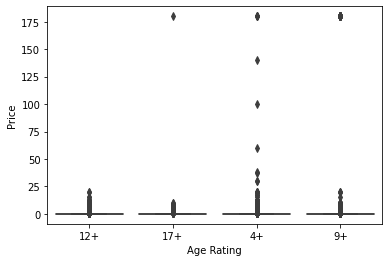

In [68]:
sns.boxplot(x='Age Rating', y='Price', data = data_raw)
pass

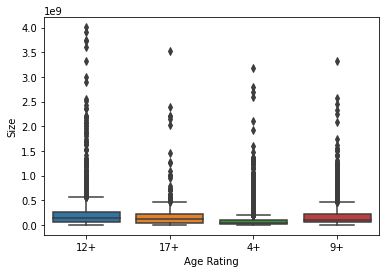

In [69]:
sns.boxplot(x='Age Rating', y='Size', data = data_raw)

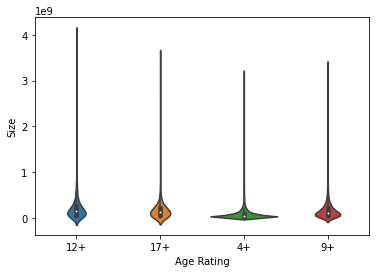

In [70]:
sns.violinplot(x='Age Rating', y='Size', data = data_raw)

### Вычисление корреляции

In [71]:
from sklearn.preprocessing import LabelEncoder
corr_data = data_raw.copy()

le = LabelEncoder()

corr_data['Developer'] = le.fit_transform(corr_data['Developer'])
corr_data['Age Rating'] = le.fit_transform(corr_data['Age Rating'])
corr_data['Primary Genre'] = le.fit_transform(corr_data['Primary Genre'])

In [72]:
corr_data['Developer']

0        4801
1        3992
2         905
3        4801
4        6067
         ... 
17002    8018
17003    6789
17004    7494
17005    6987
17006    8441
Name: Developer, Length: 17007, dtype: int64

In [73]:
corr_mat_full = corr_data.corr()
corr_mat_full

,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Size,Primary Genre,Original Release Date,Current Version Release Date,Action,Adventure,Animals & Nature,Art,Board,Books,Business,Card,Casino,Casual,Comics & Cartoons,Education,Emoji & Expressions,Entertainment,Family,Finance,Food & Drink,Games,Gaming,Health & Fitness,Kids & Family,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,People,Photo & Video,Places & Objects,...,PA,PL,PS,PT,QU,RN,RO,RU,RW,SA,SD,SE,SI,SK,SL,SO,SQ,SR,SU,SV,SW,TA,TE,TG,TH,TI,TK,TL,TO,TR,TT,UG,UK,UR,UZ,VI,XH,YI,ZH,ZU
Average User Rating,1.000000,0.007339,0.010916,-0.024902,0.010897,0.018507,-0.015571,-0.013807,-0.289427,-0.188967,-0.003242,-0.003883,0.005479,0.003874,-0.069857,-0.001326,-0.006735,-0.018160,0.008349,0.062929,0.003874,0.031447,0.008802,-0.039464,0.020612,-0.005007,0.005822,NaN,0.006685,0.009967,-0.011460,0.017566,0.009756,-0.011318,0.007083,0.001552,0.006433,0.004745,0.008090,0.005479,...,-0.007438,-0.016320,0.004745,-0.022774,0.002739,0.002739,-0.002299,-0.032558,0.002739,0.004745,0.004745,-0.012073,-0.000708,-0.007808,-0.010910,0.004745,-0.003609,0.005971,0.002739,-0.014705,0.001944,-0.003884,-0.009300,0.003874,0.007491,0.002739,0.003874,0.006664,0.002739,-0.002817,0.002739,0.002739,-0.001668,0.005505,0.005479,0.004503,0.002739,0.003874,-0.006589,-0.000150
User Rating Count,0.007339,1.000000,-0.003868,0.043768,0.011315,0.007664,0.040466,0.001677,0.041243,-0.038443,0.044429,-0.001264,-0.000787,-0.000556,-0.009009,-0.002036,-0.002253,-0.001842,-0.001613,-0.009470,-0.000556,-0.011016,-0.001527,0.014812,-0.005337,0.005127,-0.002961,NaN,-0.001972,0.018400,-0.000686,-0.004362,-0.000343,-0.000793,-0.001924,0.004235,-0.001755,-0.000681,-0.001840,-0.000787,...,0.014068,0.014148,0.021929,0.077482,-0.000213,-0.000213,0.008788,0.067940,-0.000213,-0.000577,-0.000577,-0.000818,0.013946,0.004150,0.018209,-0.000577,0.010767,0.014260,-0.000213,0.005828,0.013759,0.017960,0.021759,0.027135,0.058784,-0.000213,0.027135,-0.001497,-0.000213,0.069330,-0.000213,-0.000213,0.009850,0.019912,0.018795,0.050621,-0.000393,-0.000429,0.052715,-0.000884
Price,0.010916,-0.003868,1.000000,-0.060968,-0.068847,0.038808,0.033067,-0.005679,0.006421,-0.004449,-0.023643,-0.012965,0.000348,-0.000439,0.013855,-0.002056,0.006619,-0.007183,-0.004306,-0.023885,-0.000439,0.008467,0.001188,-0.048434,-0.015315,0.017374,-0.003557,NaN,0.000881,-0.003138,-0.000258,-0.009232,-0.000795,-0.001372,-0.004914,-0.003082,-0.000872,0.000301,0.000520,0.000348,...,-0.003555,-0.014560,0.001444,-0.016962,-0.000795,-0.000795,-0.012317,-0.016292,-0.000795,-0.001378,-0.001378,-0.002051,-0.002105,-0.010328,-0.003479,-0.001378,-0.001165,-0.003214,-0.000795,-0.016236,-0.000258,-0.004877,-0.003963,-0.001125,-0.015050,-0.000795,-0.001125,-0.002224,-0.000795,-0.019832,-0.000795,-0.000795,-0.009734,-0.002348,0.000853,-0.013526,0.004091,0.002331,-0.024708,0.000407
In-app Purchases,-0.024902,0.043768,-0.060968,1.000000,0.000533,-0.033215,0.153478,-0.003294,0.038206,-0.033497,0.038437,-0.004190,-0.013923,-0.009844,-0.059111,-0.007924,0.001543,-0.002715,0.001994,-0.043217,-0.009844,-0.084137,-0.026970,0.022969,0.037320,0.015040,0.008688,NaN,-0.034829,0.001694,-0.012057,-0.008768,0.008448,0.010704,0.012897,-0.015030,-0.008367,-0.012057,0.002178,-0.013923,...,0.044306,0.028012,0.005736,0.095994,0.008448,0.008448,0.053341,0.118291,0.008448,0.014633,0.014633,-0.004505,-0.000945,0.052415,0.037174,0.014633,0.000143,0.008302,0.008448,-0.005761,-0.006770,0.028356,0.035314,0.011947,0.062326,0.008448,0.011947,-0.000478,0.008448,0.051873,0.008448,0.008448,0.070204,0.008547,0.009192,0.062056,-0.006961,0.001051,0.096201,-0.015567
Developer,0.010897,0.011315,-0.068847,0.000533,1.000000,-0.011190,-0.010054,0.001426,-0.021110,0.003302,0.017829,0.033058,-0.020779,0.010329,-0.008928,0.020511,-0.001172,-0.017219,-0.006887,-0.006537,-0.005178,-0.026054,-0.022932,0.022399,-0.029590,-0.004155,0.007357,NaN,-0.024138,0.010138,0.005594,0.019546,0.

In [74]:
corr_mat_full.loc['Medical', 'Size']

-0.0023097398029875214

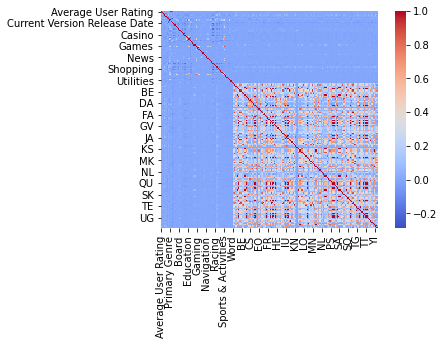

In [75]:
sns.heatmap(corr_mat_full, square=True, cmap='coolwarm')
pass

К сожалению, признаки слабо коррелируются между собой.
Хорошо коррелируются между собой языки, но это вряд ли поможет в решении поставленной задачи


Проделаем это для урезанных значений:

In [76]:
corr_mat = data_vis.corr()
corr_mat

,Average User Rating,User Rating Count,Price,In-app Purchases,Size,Original Release Date,Current Version Release Date
Average User Rating,1.000000,0.007339,0.010916,-0.024902,-0.015571,-0.289427,-0.188967
User Rating Count,0.007339,1.000000,-0.003868,0.043768,0.040466,0.041243,-0.038443
Price,0.010916,-0.003868,1.000000,-0.060968,0.033067,0.006421,-0.004449
In-app Purchases,-0.024902,0.043768,-0.060968,1.000000,0.153478,0.038206,-0.033497
Size,-0.015571,0.040466,0.033067,0.153478,1.000000,-0.179474,-0.226219
Original Release Date,-0.289427,0.041243,0.006421,0.038206,-0.179474,1.000000,0.607099
Current Version Release Date,-0.188967,-0.038443,-0.004449,-0.033497,-0.226219,0.607099,1.000000


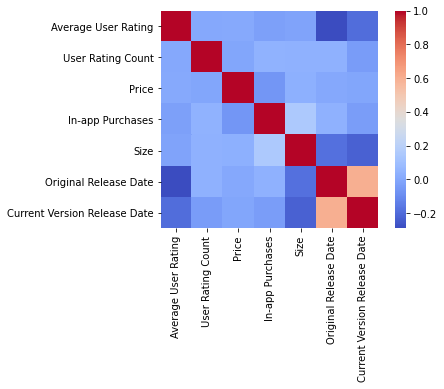

In [77]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')

Видим много синего цвета - данные слабо коррелированы

In [78]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

Original Release Date  Current Version Release Date    0.607099
dtype: float64

Видим что даты релиза и последнего обновления коррелируются хорошо, но поможет ли нам это решить задачу ?

Делаем вывод об очень слыбой корреляции признаков для урезанных данных.
Проделаем это для полных данных

In [79]:
pd.options.display.max_rows = 2000

In [80]:
corr_mat_full.where(np.triu(corr_mat_full > 0.5, k=1)).stack().sort_values(ascending=False)

IU                     MG                              1.000000
QU                     TI                              1.000000
                       SU                              1.000000
GD                     QU                              1.000000
BO                     KS                              1.000000
GD                     MG                              1.000000
QU                     RW                              1.000000
                       RN                              1.000000
BO                     OM                              1.000000
GD                     JV                              1.000000
BO                     OR                              1.000000
GD                     IU                              1.000000
                       GV                              1.000000
                       GN                              1.000000
BO                     SA                              1.000000
IU                     UG               

Большинство корреляций связывают между собой наличие языков, однако есть несколько и других признаков, например,
Gaming                 Stickers                        0.897868
Emoji & Expressions    Stickers                        0.695281

### Удаление признаков с очень слабой корреляцией

In [81]:
corr_mat_full.loc[:, 'Age Rating'].sort_values(ascending=False)

Age Rating                      1.000000
Puzzle                          0.081639
Current Version Release Date    0.074395
Casual                          0.055209
Family                          0.049809
Original Release Date           0.039482
Price                           0.038808
Education                       0.027066
HE                              0.022581
EL                              0.022525
FI                              0.021437
Board                           0.021339
NB                              0.021254
Average User Rating             0.018507
DA                              0.018136
HU                              0.017786
Racing                          0.016306
SK                              0.015949
Utilities                       0.013563
MS                              0.011838
Word                            0.011834
VI                              0.011485
Trivia                          0.011275
Entertainment                   0.011086
Health & Fitness

# Бинаризация номинальных признаков

In [82]:
data_raw.describe(include=['category'])

,Developer,Age Rating,Primary Genre
count,17007,17007,17007
unique,8693,4,21
top,Tapps Tecnologia da Informa\xe7\xe3o Ltda.,4+,Games
freq,123,11806,16286


У нас есть три категориальных признака, их нужно преобразовать в числовой(бинарный)
Age Rating - лейбл

In [83]:
primary_genre = pd.get_dummies(data_raw['Primary Genre'])

In [84]:
primary_genre[-20:]

,Book,Business,Education,Entertainment,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Medical,Music,Navigation,News,Productivity,Reference,Shopping,Social Networking,Sports,Stickers,Travel,Utilities
16987,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16988,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16989,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16990,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16991,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16992,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16993,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16994,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16995,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16996,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
data_raw = pd.concat((data_raw, primary_genre), axis=1)
data_raw = data_raw.drop(['Primary Genre'], axis=1)

In [86]:
developer = pd.get_dummies(data_raw['Developer'])

In [87]:
data_raw = pd.concat((data_raw, developer), axis=1)
data_raw = data_raw.drop(['Developer'], axis=1)

In [88]:
data_raw.columns

Index(['Average User Rating', 'User Rating Count', 'Price', 'In-app Purchases',
       'Age Rating', 'Size', 'Original Release Date',
       'Current Version Release Date', 'Action', 'Adventure',
       ...
       'zhiguo lin', 'zhijuan zhang', 'zhili zhao', 'zhixiang zhao',
       'zhong chen', 'zhou zhimeng', 'zinWorks Studios (zinCode, LLC)',
       'zomido med', 'zuiyouqu youxi', 'zurab inaishvili'],
      dtype='object', length=8883)

In [89]:
data_raw['Age Rating'].unique()

['4+', '9+', '12+', '17+']
Categories (4, object): ['4+', '9+', '12+', '17+']

In [90]:

le = preprocessing.LabelEncoder()

In [91]:
fit_labels = pd.unique(data_raw['Age Rating'])
le.fit(fit_labels)
data_raw['Age Rating'] = le.transform(data_raw['Age Rating'])

# Нормализация количественных признаков

### Проведем ее в следующем разделе

# Разобьем данные на обучающую и тестовую выборки

 в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [188]:
y = data_raw.loc[:,'Age Rating']
x = data_raw.loc[:,:]

Нормализуем числовые признаки:

In [189]:
x = (x - x.mean(axis = 0))/x.std(axis = 0) 

In [94]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: Age Rating, dtype: int64

In [190]:
x.columns[x.isna().any()].tolist()

['Games']

Каким образом произошло то, что в столбце Games обнаружено Nan - я понять так и не смог

In [191]:
# удаляем строки, в которых встречается Nan

x.dropna()

,Average User Rating,User Rating Count,Price,In-app Purchases,Age Rating,Size,Original Release Date,Current Version Release Date,Action,Adventure,Animals & Nature,Art,Board,Books,Business,Card,Casino,Casual,Comics & Cartoons,Education,Emoji & Expressions,Entertainment,Family,Finance,Food & Drink,Games,Gaming,Health & Fitness,Kids & Family,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,People,Photo & Video,Places & Objects,Productivity,Puzzle,...,yongcheng wu,yongho choi,youssef rahali,yu du,yu liu,yu yan,yuanteng li,yuejian wang,yujiro komine,yungang wang,yvan suprina petrovic,ywqc studio,zaai developer,zahid awan,zahida alam,zakaria fathy,zang jing,ze bai,zenithal softwares,zhang dan,zhang dui long,zhang jun,zhang xu,zhang yan,zhe zhang,zhen qu,zhendong song,zheng jinwan,zheng yonge,zhicheng huang,zhiguo lin,zhijuan zhang,zhili zhao,zhixiang zhao,zhong chen,zhou zhimeng,"zinWorks Studios (zinCode, LLC)",zomido med,zuiyouqu youxi,zurab inaishvili


In [192]:
x.columns[x.isna().any()].tolist()

['Games']

Как мы видим, нам это не помогло.
Попробовав разные сопособы, я решил распрошаться с данным столбцом, так как он не несет в себе чего-то важного (и плохо коррелируется)

In [193]:
x.drop(['Games'], axis='columns', inplace=True)

In [194]:
x.columns[x.isna().any()].tolist()

[]

Ура, Nan снова пропал из нашего dataFrame 

In [195]:
x.drop(['Age Rating'], axis='columns', inplace=True)
# удалили лейбл значение из тестовой выборки

In [196]:
print(x.shape)
print(y.shape)
N, d = x.shape

(17007, 8880)
(17007,)


# Алгоритм Ближайших Соседей

In [199]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

N_train, _ = x_train.shape 
N_test,  _ = x_test.shape 

print(N_train, N_test)

12755 4252


In [200]:

knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors = 5)


In [201]:
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [202]:
err_train = np.mean(y_train != knn.predict(x_train))  
err_test  = np.mean(y_test  != knn.predict(x_test))

In [203]:
print(err_train, err_test)

0.23943551548412387 0.270931326434619


Для другого количества соседей

In [ ]:
model = KNeighborsClassifier(n_neighbors=8).fit(x_train, y_train)
pred_y = model.predict(x_test)



In [ ]:
print("R2-SCORE ", r2_score(y_test, pred_y)) 
print("ACCURACY ", accuracy_score(y_test, pred_y))

In [ ]:
model2 = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)
pred_y2 = model2.predict(x_test)

In [ ]:
print("R2-SCORE ", r2_score(y_test, pred_y2)) 
print("ACCURACY ", accuracy_score(y_test, pred_y2))

In [ ]:
%%time
model3 = KNeighborsClassifier(n_neighbors=15).fit(x_train, y_train)
pred_y3 = model3.predict(x_test)

In [ ]:
print("R2-SCORE ", r2_score(y_test, pred_y3)) 
print("ACCURACY ", accuracy_score(y_test, pred_y3))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.333, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=1000).fit(x_train, y_train)
pred_y = model.predict(x_test) 

print("R2-SCORE ", r2_score(y_test, pred_y)) 
print("ACCURACY ", accuracy_score(y_test, pred_y))

# PCA

In [106]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [113]:
x_tr = x_train.copy()

In [156]:
%%time
pca_model = PCA(n_components = 2)
pca_model.fit(x)
print(x.shape)
print(f"Главные компоненты:\n {pca_model.components_.shape}")
print(f"Дисперсии по главным компонентам:\n {pca_model.explained_variance_}")

(17007, 8880)
Главные компоненты:
 (2, 8880)
Дисперсии по главным компонентам:
 [36.52599453 19.6920082 ]
CPU times: user 17.4 s, sys: 528 ms, total: 17.9 s
Wall time: 10.6 s


In [157]:
x_proj = pca_model.transform(x)
print(x.shape)
print(x_proj.shape)

(17007, 8880)
(17007, 2)


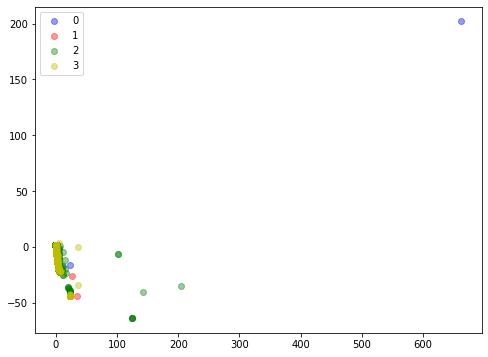

In [158]:
plt.figure(figsize = (8, 6))
colors = ['b', 'r', 'g', 'y']
for k in range(4):
    plt.scatter(x_proj[y == k, 0], x_proj[y == k, 1], color = colors[k], alpha = 0.4, label = str(k))
plt.legend()

In [149]:

from sklearn.svm import SVC

In [150]:
svm = SVC()

In [152]:
svm.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [153]:
print("Train accuracy: {}. Test accuracy: {}".format(svm.score(x_train, y_train), svm.score(x_test, y_test)))

Train accuracy: 0.9146217169737358. Test accuracy: 0.7476481655691439


In [154]:
results = pd.DataFrame(columns = ["Components", "Train_acc", "Test_acc"])

In [161]:
%%time
for n_comp in range(1, 25):
    pca = PCA(n_components=n_comp)
    x_pca = pca.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)
    svm = SVC()
    svm.fit(x_train, y_train)
    comp_result = {"Components": n_comp, "Train_acc" : svm.score(x_train, y_train), "Test_acc" : svm.score(x_test, y_test)}
    results = results.append(comp_result, ignore_index=True)

CPU times: user 12min 58s, sys: 8.74 s, total: 13min 6s
Wall time: 9min 30s


In [162]:
results

,Components,Train_acc,Test_acc
0,1.0,0.694551,0.694967
1,2.0,0.695257,0.694732
2,3.0,0.695335,0.694732
3,4.0,0.695335,0.694732
4,5.0,0.695414,0.694732
5,6.0,0.695492,0.694732
6,7.0,0.695414,0.694732
7,8.0,0.695492,0.694732
8,9.0,0.695806,0.694967
9,10.0,0.695806,0.695202


In [163]:
import matplotlib.pyplot as plt

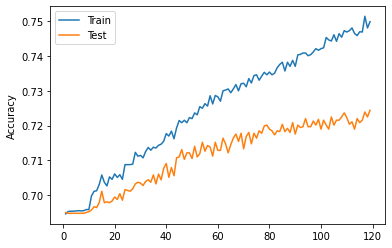

In [179]:
plt.plot(results.Components, results.Train_acc, label="Train")
plt.plot(results.Components, results.Test_acc, label = "Test")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [166]:
%%time
for n_comp in range(26, 30):
    pca = PCA(n_components=n_comp)
    x_pca = pca.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)
    svm = SVC()
    svm.fit(x_train, y_train)
    comp_result = {"Components": n_comp, "Train_acc" : svm.score(x_train, y_train), "Test_acc" : svm.score(x_test, y_test)}
    results = results.append(comp_result, ignore_index=True)

CPU times: user 2min 51s, sys: 2.01 s, total: 2min 53s
Wall time: 2min 9s


In [168]:
%%time
for n_comp in range(30, 40):
    pca = PCA(n_components=n_comp)
    x_pca = pca.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)
    svm = SVC()
    svm.fit(x_train, y_train)
    comp_result = {"Components": n_comp, "Train_acc" : svm.score(x_train, y_train), "Test_acc" : svm.score(x_test, y_test)}
    results = results.append(comp_result, ignore_index=True)

CPU times: user 7min 53s, sys: 5.36 s, total: 7min 59s
Wall time: 6min


In [172]:
%%time
for n_comp in range(40, 60):
    pca = PCA(n_components=n_comp)
    x_pca = pca.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)
    svm = SVC()
    svm.fit(x_train, y_train)
    comp_result = {"Components": n_comp, "Train_acc" : svm.score(x_train, y_train), "Test_acc" : svm.score(x_test, y_test)}
    results = results.append(comp_result, ignore_index=True)

CPU times: user 18min 45s, sys: 34 s, total: 19min 19s
Wall time: 14min 28s


In [174]:
%%time
for n_comp in range(60, 80):
    pca = PCA(n_components=n_comp)
    x_pca = pca.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)
    svm = SVC()
    svm.fit(x_train, y_train)
    comp_result = {"Components": n_comp, "Train_acc" : svm.score(x_train, y_train), "Test_acc" : svm.score(x_test, y_test)}
    results = results.append(comp_result, ignore_index=True)

CPU times: user 25min, sys: 59.5 s, total: 25min 59s
Wall time: 19min 39s


In [176]:
%%time
for n_comp in range(80, 100):
    pca = PCA(n_components=n_comp)
    x_pca = pca.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)
    svm = SVC()
    svm.fit(x_train, y_train)
    comp_result = {"Components": n_comp, "Train_acc" : svm.score(x_train, y_train), "Test_acc" : svm.score(x_test, y_test)}
    results = results.append(comp_result, ignore_index=True)

CPU times: user 31min 43s, sys: 1min 12s, total: 32min 55s
Wall time: 25min 27s


In [178]:
%%time
for n_comp in range(100, 120):
    pca = PCA(n_components=n_comp)
    x_pca = pca.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)
    svm = SVC()
    svm.fit(x_train, y_train)
    comp_result = {"Components": n_comp, "Train_acc" : svm.score(x_train, y_train), "Test_acc" : svm.score(x_test, y_test)}
    results = results.append(comp_result, ignore_index=True)

CPU times: user 37min 49s, sys: 48.9 s, total: 38min 38s
Wall time: 30min 27s


In [184]:
results.sort_values(by=['Test_acc'])

,Components,Train_acc,Test_acc
0,1.0,0.694551,0.694967
1,2.0,0.695257,0.694732
2,3.0,0.695335,0.694732
3,4.0,0.695335,0.694732
4,5.0,0.695414,0.694732
6,7.0,0.695414,0.694732
5,6.0,0.695492,0.694732
7,8.0,0.695492,0.694732
8,9.0,0.695806,0.694967
9,10.0,0.695806,0.695202


In [185]:
pca = PCA(n_components=115)
x_pca = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state = 42)

model = RandomForestClassifier(n_estimators=1000).fit(x_train, y_train)
pred_y = model.predict(x_test) 

print("R2-SCORE ", r2_score(y_test, pred_y)) 
print("ACCURACY ", accuracy_score(y_test, pred_y))

R2-SCORE  -0.09710439620605671
ACCURACY  0.7648165569143932


In [171]:
x.columns[100:200]

Index(['KM', 'KN', 'KO', 'KR', 'KS', 'KU', 'KY', 'LA', 'LO', 'LT', 'LV', 'MG',
       'MI', 'MK', 'ML', 'MN', 'MR', 'MS', 'MT', 'MY', 'NB', 'NE', 'NL', 'NN',
       'NO', 'OM', 'OR', 'PA', 'PL', 'PS', 'PT', 'QU', 'RN', 'RO', 'RU', 'RW',
       'SA', 'SD', 'SE', 'SI', 'SK', 'SL', 'SO', 'SQ', 'SR', 'SU', 'SV', 'SW',
       'TA', 'TE', 'TG', 'TH', 'TI', 'TK', 'TL', 'TO', 'TR', 'TT', 'UG', 'UK',
       'UR', 'UZ', 'VI', 'XH', 'YI', 'ZH', 'ZU', 'Book', 'Business',
       'Education', 'Entertainment', 'Finance', 'Food & Drink',
       'Health & Fitness', 'Lifestyle', 'Medical', 'Music', 'Navigation',
       'News', 'Productivity', 'Reference', 'Shopping', 'Social Networking',
       'Sports', 'Stickers', 'Travel', 'Utilities', '"Alex Artem'ev"',
       '"ByteRockers' Games GmbH & Co. KG"', '"Daniel O'Sullivan"',
       '"Don't Blink Studios"', '"Ellie's Games, LLC"', '"Galen O'Shea"',
       '"Igor's Software Labs LLC"', '"It's All A Game LLC"',
       '"Joe o'donovan"', '"Joe's Apps"', '"Jo

# Выводы
имея ввиду то, что возрастное ограничение '4+' составляет 69% из всех игр, а мы имеем точность всего 71%
можно сказать, что возрастное ограничение игры, основываясь на ее жанрах, разработчике, размере, дате релиза и т.д. угадать очень сложно(по крайней мере используя метод ближайших соседей)

Лучшая точность для KNN это 72.9% при 5 соседей.

Лучший результат для PCA и SVC - 72,4%, переобучение сравнимо с KNN

Самый хороший результат я получил при методе RF и PCA: точность 0.76, 115 компонет (без PCA примерно столько же)

Таким образом На проверяемых мной количествах компонент PCA не помог на моих данных. Я связываю это с тем, что данные в датасете оказались слабо коррелируемыми и понижение размерности не сильно помогает в этом случае.

Однако заметим, что мы так и не вышли на плато по PCA, возможно с увеличение количества компонент у нас будет увеличиваться точность. Это пока не было проверено из-за долгости подсчета функций

In [ ]:
Самый хороший результат я получил при методе RF и PCA: точность 0.76, 115 компонет (без PCA примерно столько же)